In [1]:
import sys
import os
import matplotlib.pyplot as plt 


sys.path.append(os.path.abspath('../src'))

In [2]:
from networks import run_single_network, create_random_network
from utils import plot_raster, plot_adjacency_matrix


In [245]:
neurons, G = create_random_network(N=1000, p_connect=0.07, weight_bounds=(0.1,2))

In [246]:
T_seconds = 2

In [247]:
T =int( T_seconds* 2000)
V_hist, S_hist, I_syn_hist, I_ext, final_state, final_stdp_state = run_single_network(
    neurons, G, network_type='stdp_syn', T=T, nkey=32)


In [248]:
I_syn_hist.mean()/(I_syn_hist.mean()+10)

Array(0.03725629, dtype=float32)

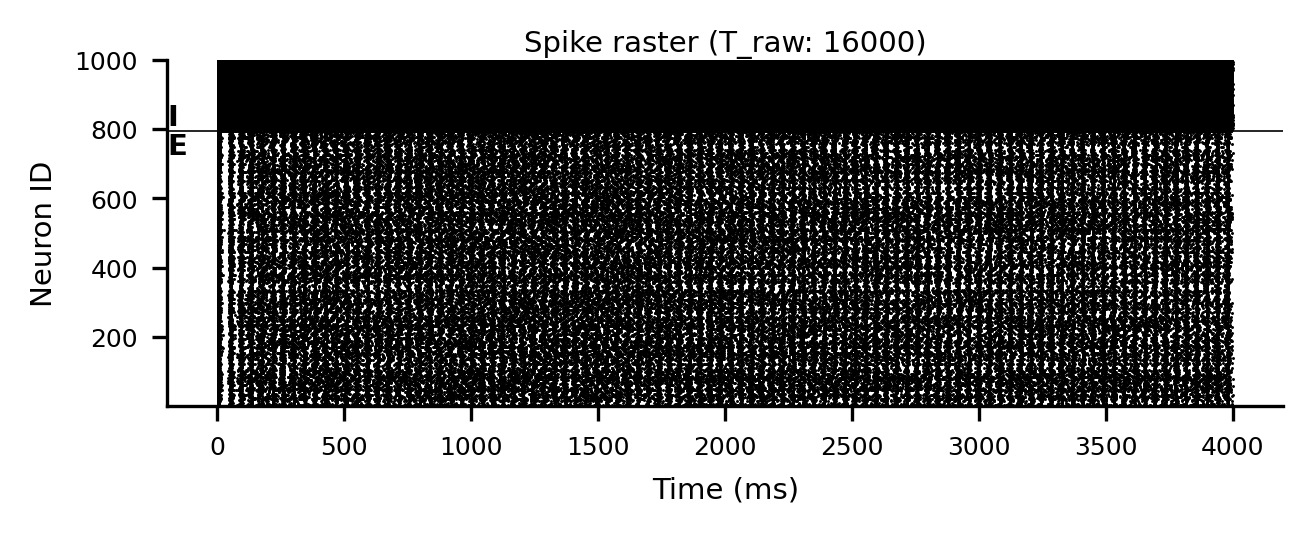

In [249]:
plot_raster(S_hist, neurons, final_state.W, T_total=T, title=f'Spike raster (T_raw: {int(T/0.25)})')
plt.show()

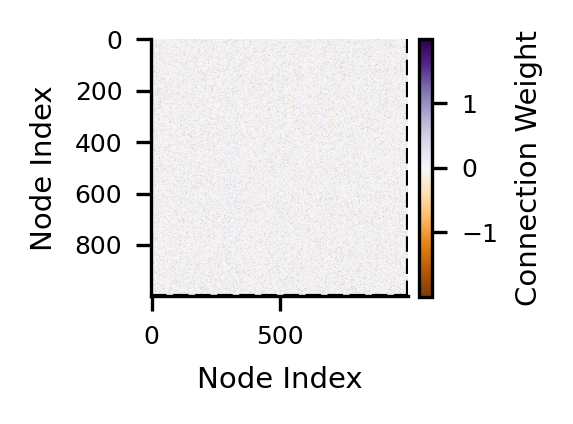

In [250]:
plot_adjacency_matrix(G, figsize=(2,2))
plt.show()

In [251]:
import infomeasure as im
import antropy as ant
import numpy as np 
from tqdm import tqdm 

In [252]:
im_args = {"approach": "miller_madow", "base": 2}


In [253]:
A = np.array(S_hist)
A.shape

(16000, 1000)

In [254]:
im.entropy(A, **im_args)

np.float64(14.68245266343271)

In [255]:
int(T/0.25)/500

32.0

100%|██████████| 8/8 [00:00<00:00, 27.68it/s]


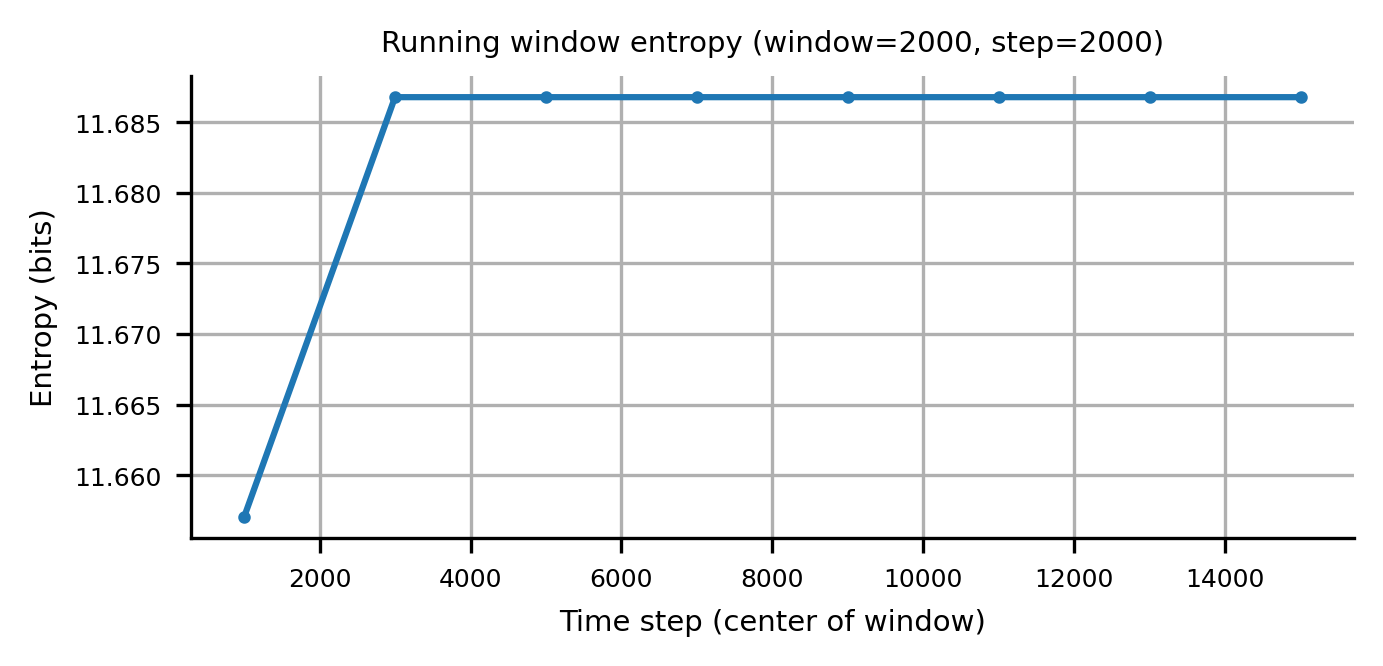

In [256]:
# Running window entropy

window_size = int(500/0.25)
step_size = window_size

entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A[start:start+window_size]
    H = im.entropy(window, **im_args)
    entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [257]:
# Scan for different window sizes
window_sizes = [50, 100, 200, 500]
step_sizes = [int(w/0.25) for w in window_sizes]
results = {}

for w, step in zip(window_sizes, step_sizes):
    window_size = int(w/0.25)
    step_size = 10 #window_size
    entropies = []
    times = []
    for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size), desc=f'Window {w}'):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)
        times.append(start + window_size//2)
    results[w] = (times, entropies)

# Plot all
plt.figure(figsize=(8,4))
for w in window_sizes:
    times, entropies = results[w]
    plt.plot(times, entropies, marker='o', markersize=2, label=f'window={w}')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title("Running window entropy for different window sizes")
plt.grid(True)
plt.legend()
plt.show()

Window 100:  91%|█████████ | 1415/1561 [00:09<00:00, 155.08it/s]


KeyboardInterrupt: 

Window 1000: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


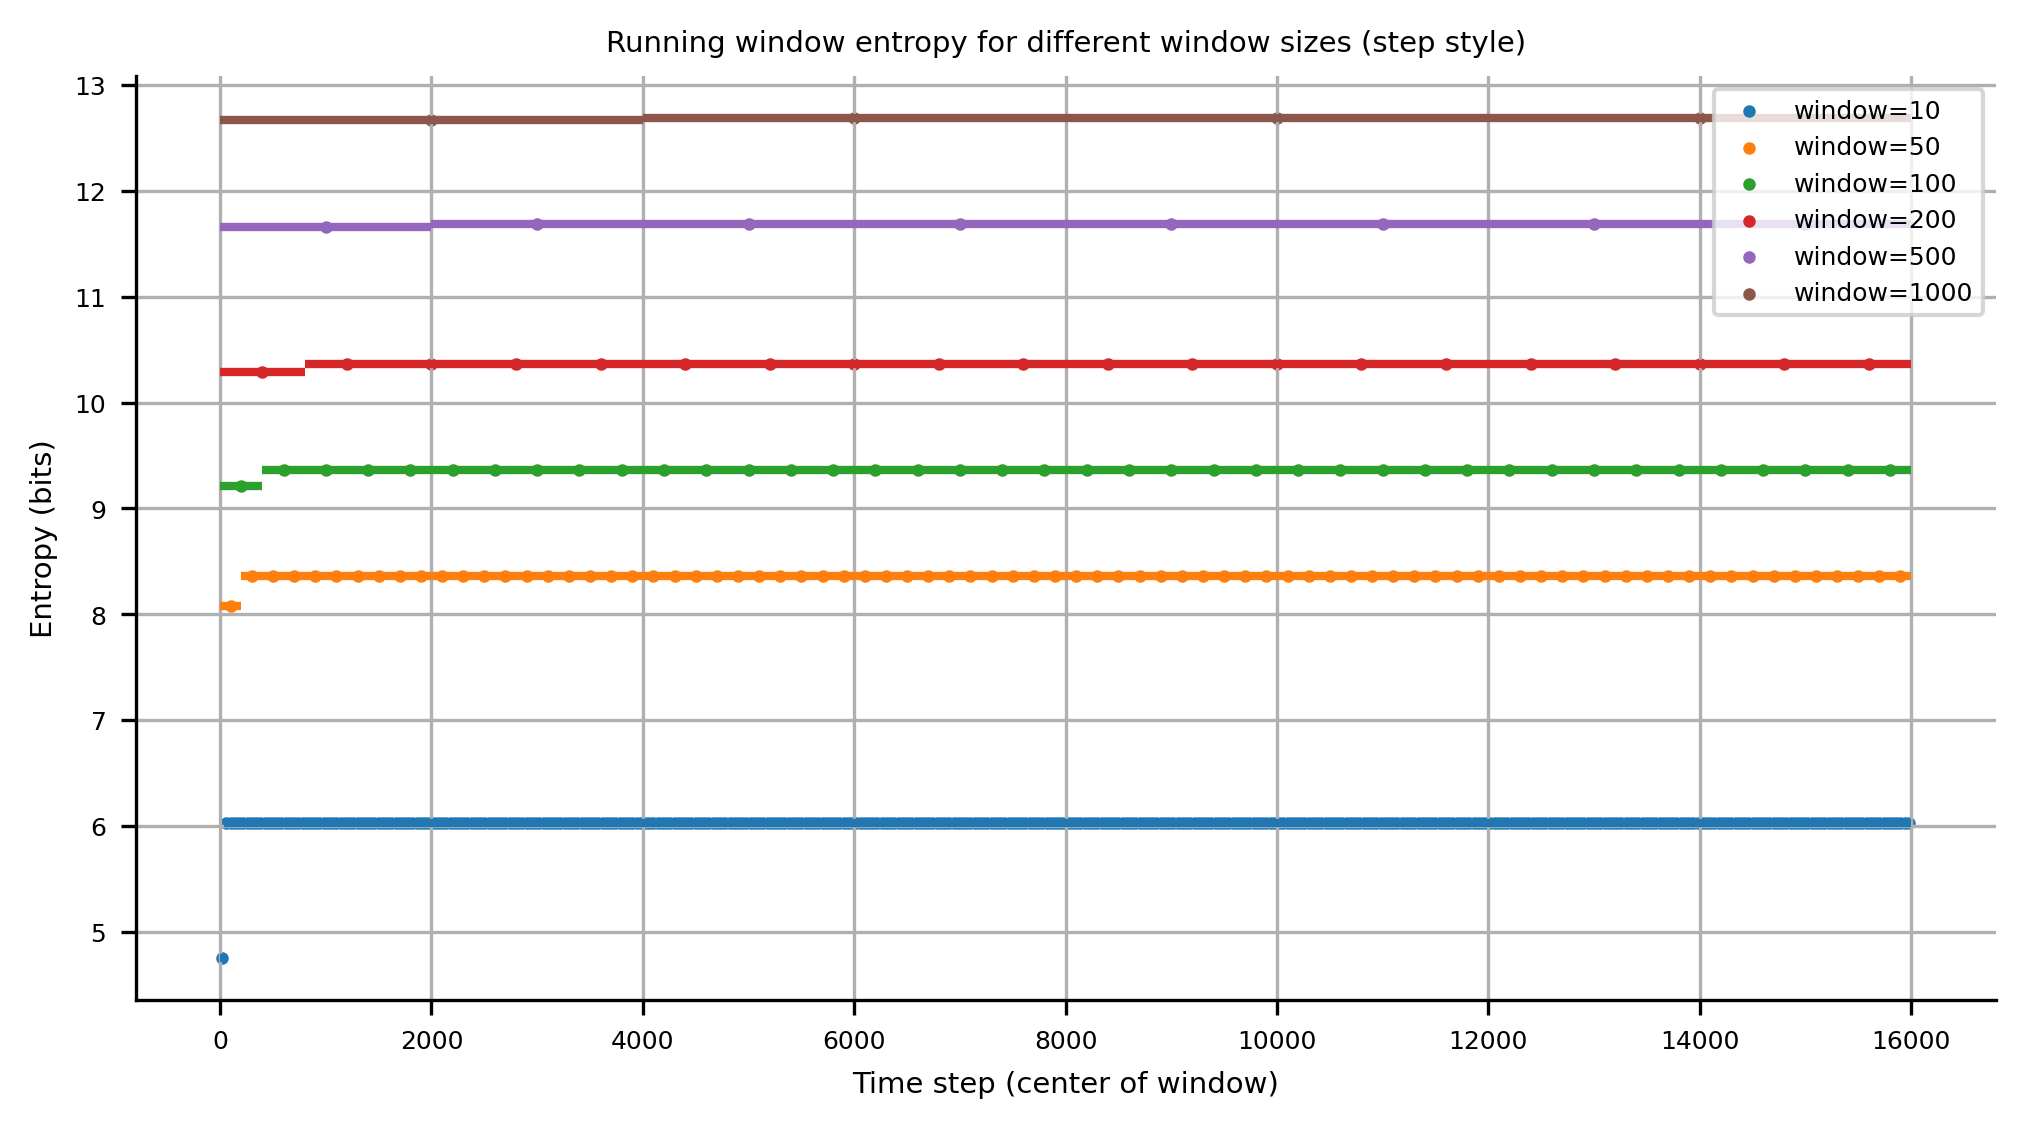

In [258]:
# Scan for different window sizes
window_sizes = [10, 50, 100, 200, 500, 1000]
step_sizes = [int(w/0.25) for w in window_sizes]
results = {}

for w, step in zip(window_sizes, step_sizes):
    window_size = int(w/0.25)
    step_size =  window_size
    entropies = []
    times = []
    for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size), desc=f'Window {w}'):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)
        times.append(start + window_size//2)
    results[w] = (times, entropies)

# Plot all as step-like horizontal lines with markers, color per window size
plt.figure(figsize=(8,4))
for idx, (w, step) in enumerate(zip(window_sizes, step_sizes)):
    times, entropies = results[w]
    color = f'C{idx}'
    for t, H in zip(times, entropies):
        left = t - (step/2)
        right = t + (step/2)
        plt.hlines(H, left, right, colors=color, linewidth=2)
    plt.scatter(times, entropies, c=color, s=4, label=f'window={w}')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title("Running window entropy for different window sizes (step style)")
plt.grid(True)
plt.legend()
plt.show()

In [226]:
def add_noise_in_window(A, a, b, p=0.01, seed=None):
    """
    Add noise to binary spike matrix A within timesteps [a, b).
    
    """
    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    
    mask = rng.random(size=A_noisy[a:b].shape) < p
    A_noisy[a:b][mask] = 1 - A_noisy[a:b][mask]
    
    return A_noisy

In [227]:
array_test = A
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

/var/folders/g8/nl718mjj3q32_ynwvrcqd2wh0000gn/T/ipykernel_18333/529999541.py:5: RuntimeWarning: invalid value encountered in scalar divide
  R_H =  num_H / den_H


np.float64(nan)

In [228]:
A_noisy = add_noise_in_window(A, 8000, 12000)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


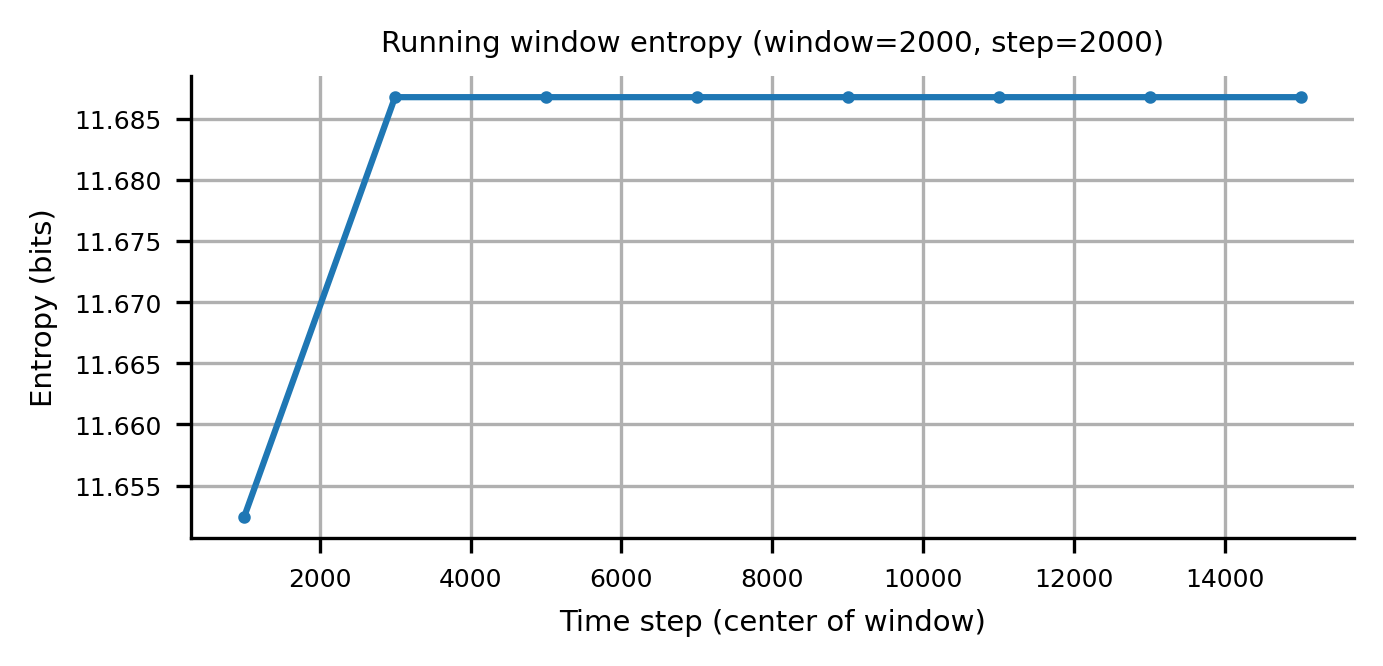

In [229]:
# Running window entropy
window_size = int(500/0.25)
step_size = window_size

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, n_entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

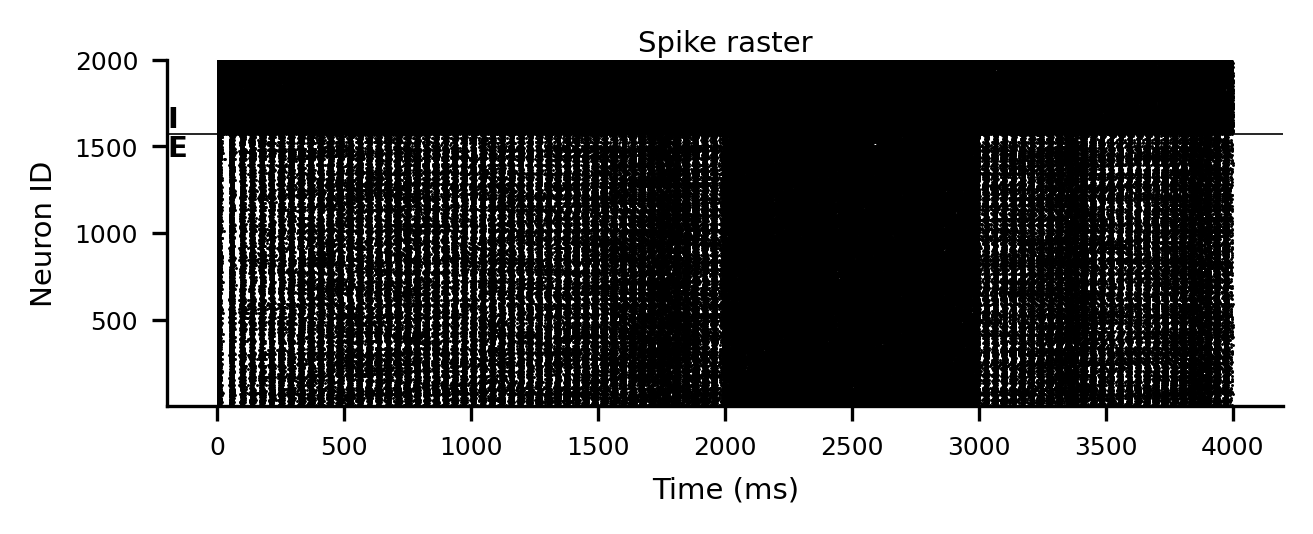

In [230]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

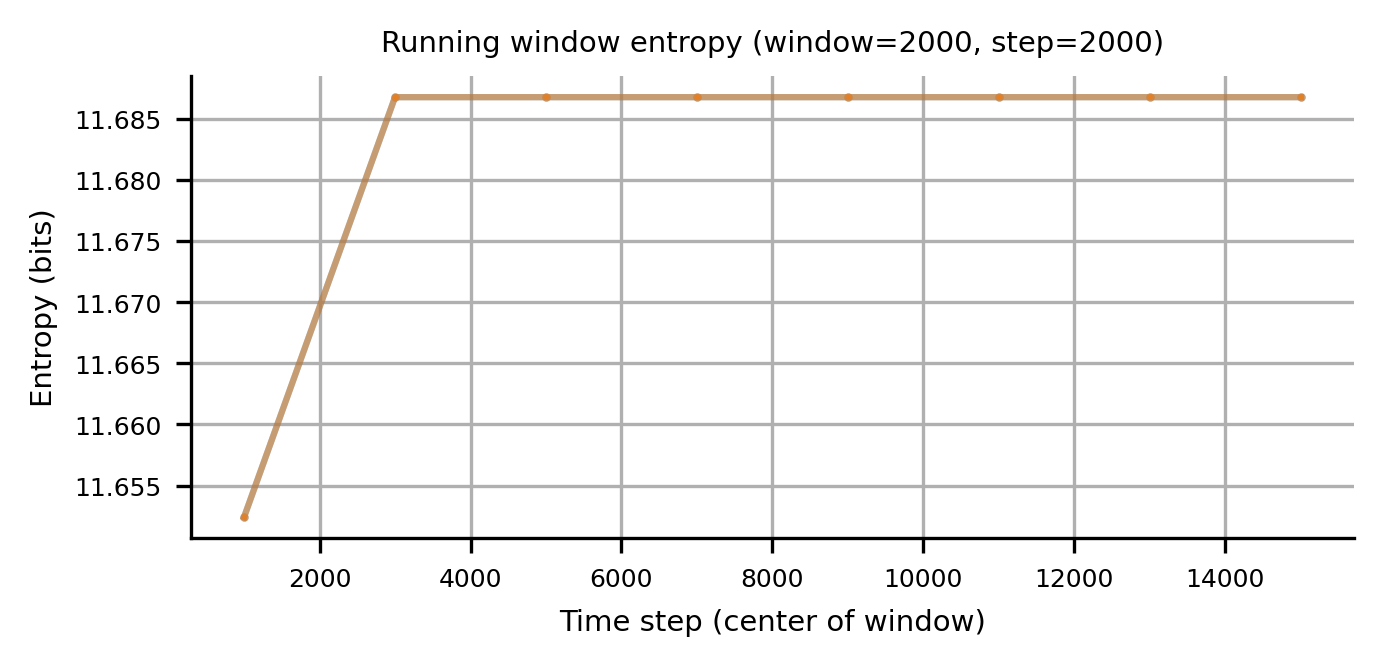

In [233]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1, alpha=0.5)
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [54]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(1.1730112734075921)

In [17]:
def add_structured_noise(A, a, b, mode="silence", p=0.2, seed=None):

    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    segment = A_noisy[a:b]

    if mode == "silence":
        mask = (segment == 1) & (rng.random(segment.shape) < p)
        segment[mask] = 0
    elif mode == "burst":
        mask = (segment == 0) & (rng.random(segment.shape) < p)
        segment[mask] = 1
    else:
        raise ValueError("mode must be 'silence' or 'burst'")

    A_noisy[a:b] = segment
    return A_noisy



In [238]:
A_silenced = add_structured_noise(A, 8000, 12000,p=0.5)

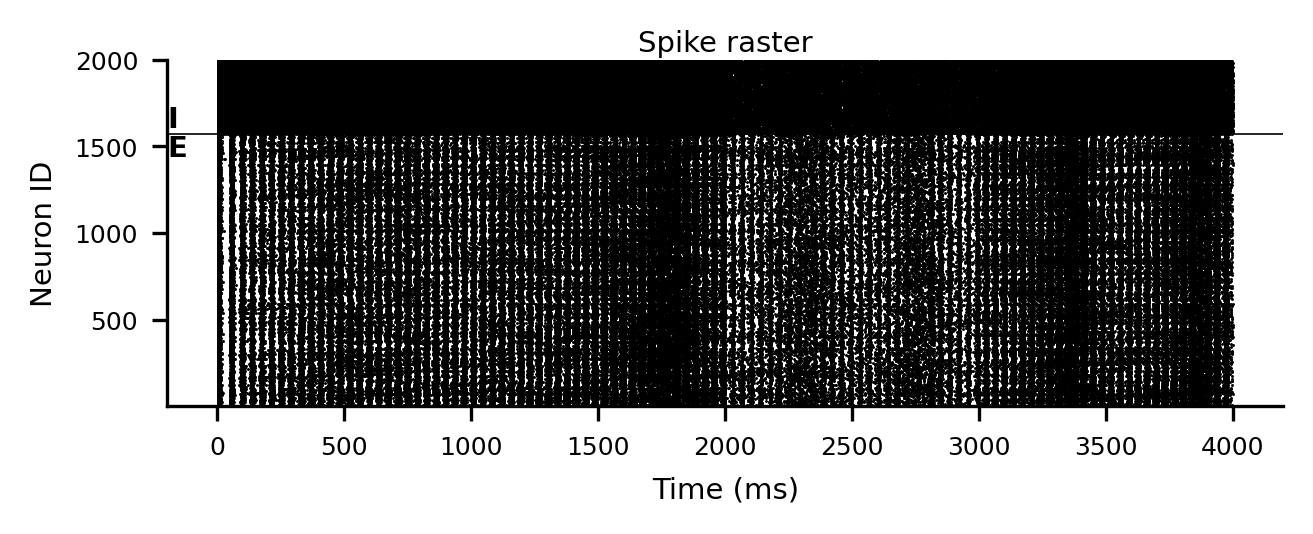

In [239]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [243]:
# Running window entropy
window_size = int(500/0.25)
step_size = window_size

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 8/8 [00:00<00:00, 17.20it/s]


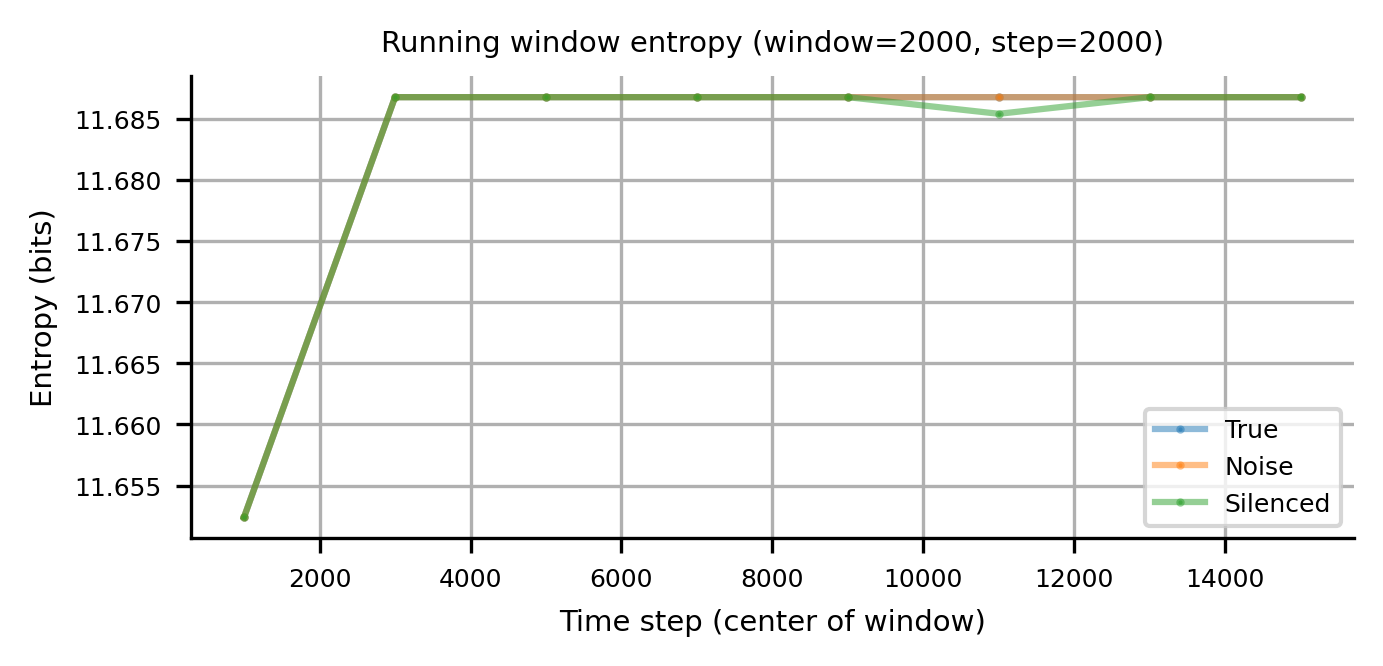

In [244]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(0.6275556156720316)

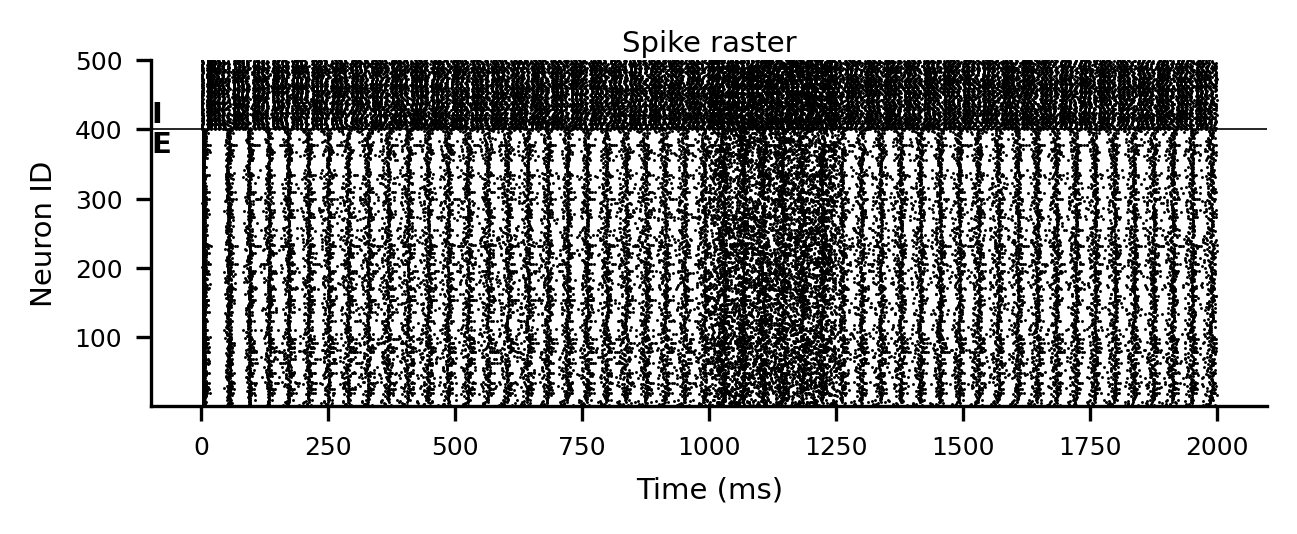

In [23]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [78]:
import jax

In [81]:
jax.devices("cpu")[0]

CpuDevice(id=0)

In [57]:
# Silence for ever
A_silenced = add_structured_noise(A, 4000, 8000)

In [25]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:19<00:00, 31.41it/s]


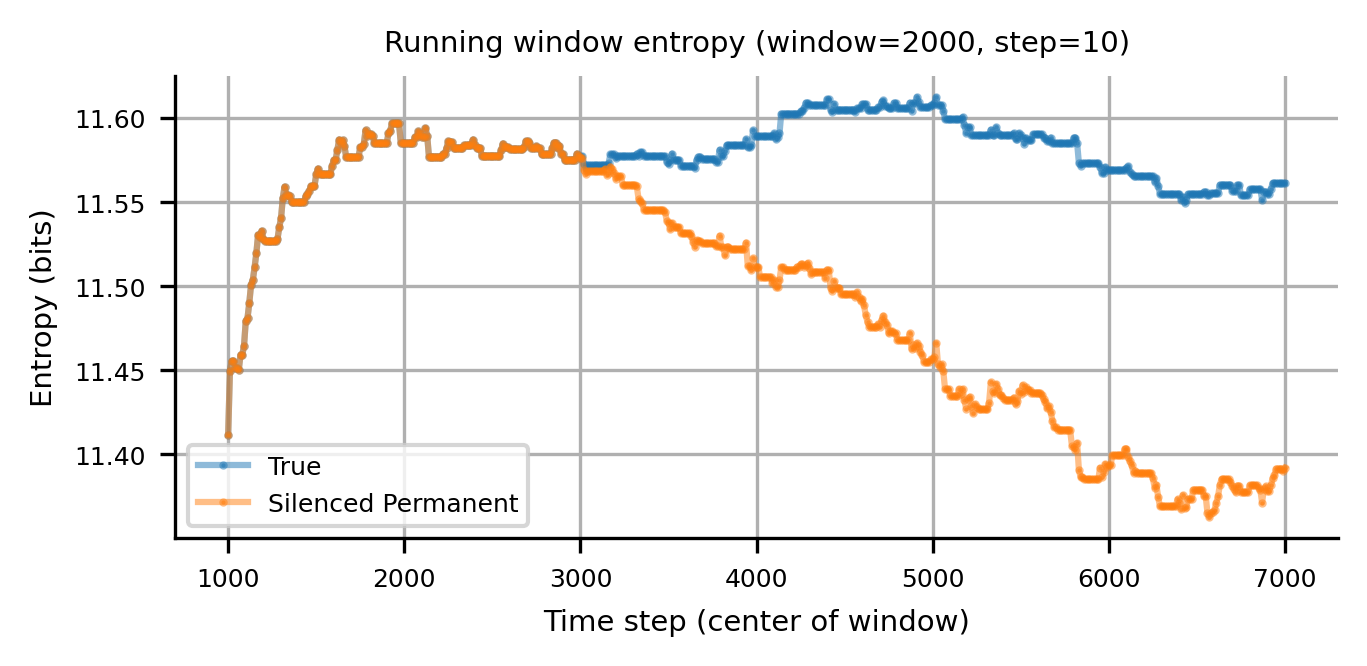

In [28]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
#plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

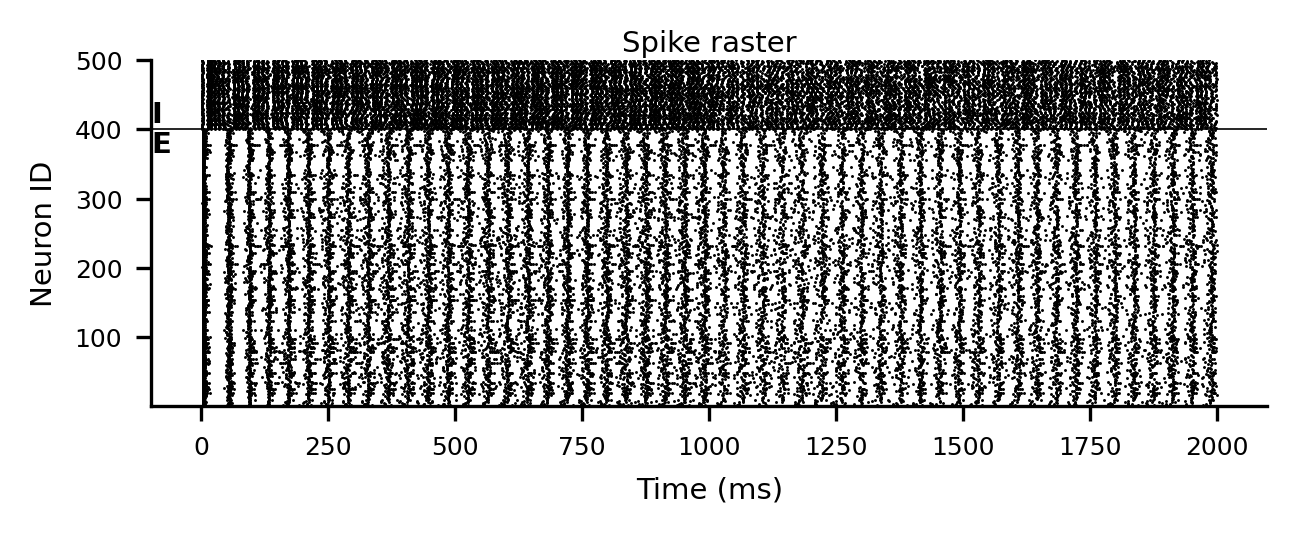

In [29]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [58]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.2959106596908949)

In [59]:
# Permantent noise
A_noisy = add_noise_in_window(A, 4000, 8000)

In [31]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:14<00:00, 42.14it/s]


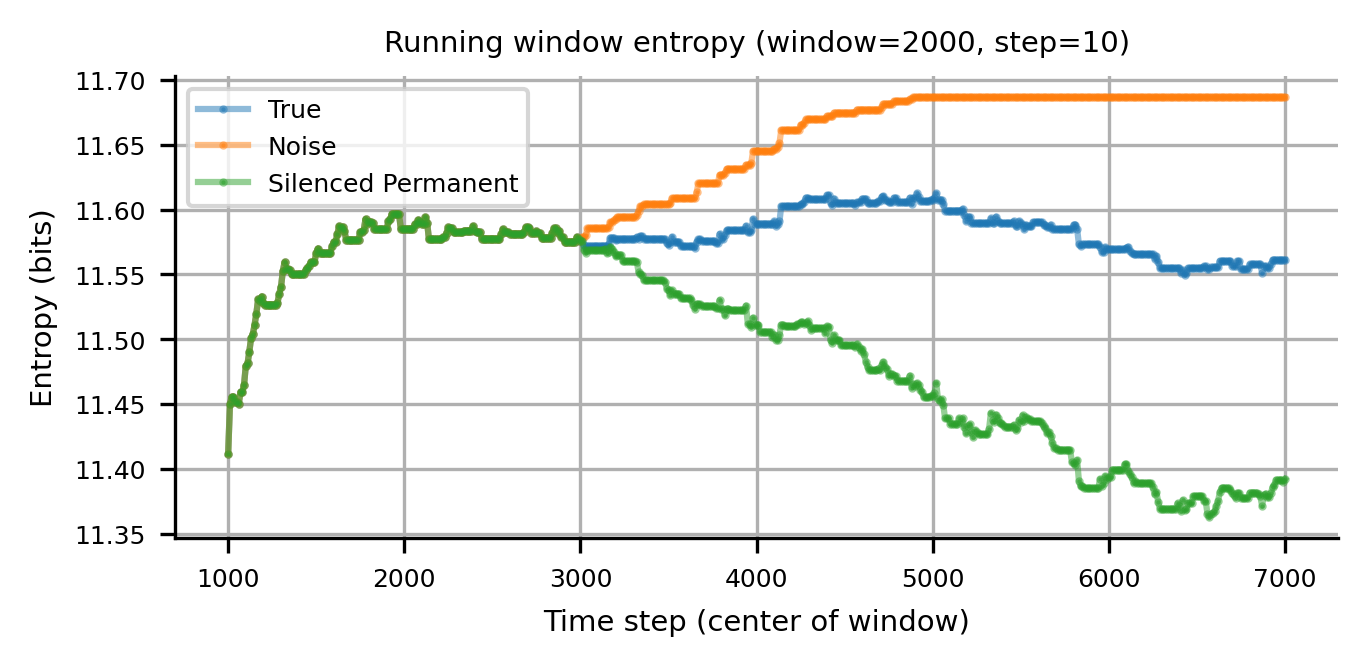

In [32]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()#

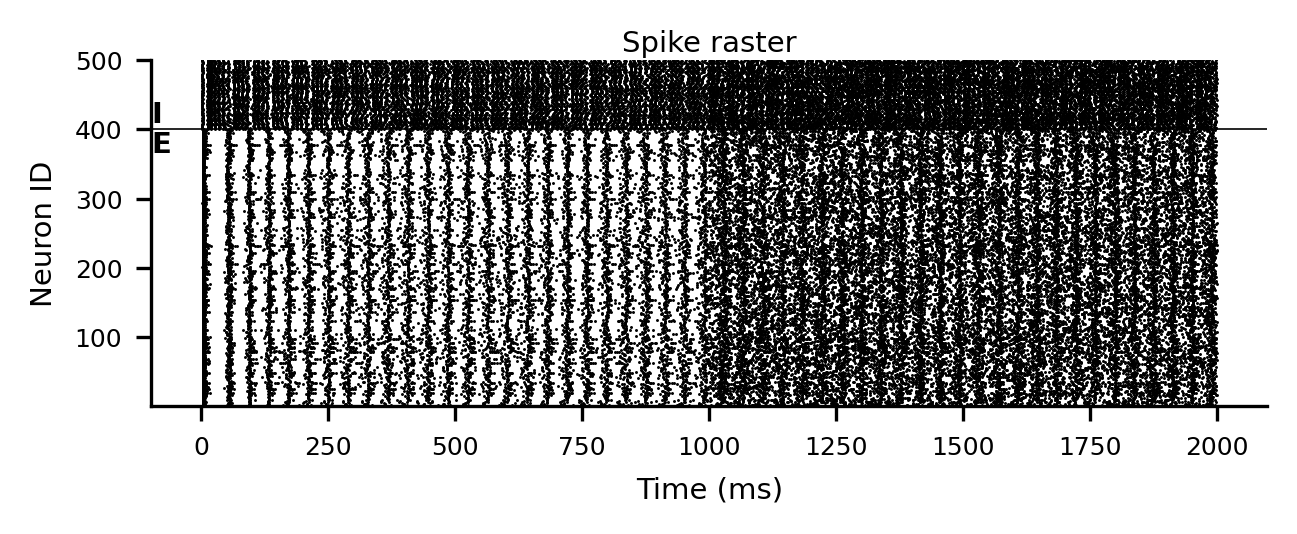

In [33]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [36]:
n_entropies[3000:4000]

[]

In [60]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.0)

In [61]:
R_H

np.float64(-0.0)

In [43]:
im.entropy(A_noisy[2000:4000], **im_args)

np.float64(11.576100544419388)

In [44]:
im.entropy(A_noisy[4000:6000], **im_args) 

np.float64(11.686771131346347)

In [45]:
im.entropy(A_noisy[6000:8000], **im_args)

np.float64(11.686771131346347)

In [49]:
A_noisy.shape

(8000, 500)